***CrediGuard: Machine Learning for Credit Default Risk Prediction***

Objective: 
1. To build a binary classification model that categorizes applicants as either "good" (low risk of default, label 0) or "bad" (high risk of default, label 1).
2. he model should achieve high recall for bad cases (to catch potential defaulters) while maintaining reasonable precision, given the imbalanced nature of the data (far more good applicants than bad).
3. We aim for a ROC AUC score above 0.8 as a benchmark for discriminatory power.

In [347]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [348]:
# Stage 1: Load the datasets
application = pd.read_csv('application_record.csv')
credit = pd.read_csv('credit_record.csv')

print("Application shape:", application.shape)
print("Credit shape:", credit.shape)

Application shape: (438557, 18)
Credit shape: (1048575, 3)


In [349]:
# Stage 2: Create target variable from credit_record
# Define bad credit if STATUS is 2,3,4,5 (60+ days overdue)
credit['STATUS'] = credit['STATUS'].replace({'C': -1, 'X': -2})  # Treat C and X as good
credit['STATUS'] = pd.to_numeric(credit['STATUS'], errors='coerce')

# Group by ID and find the maximum STATUS for each ID (worst status)
user_status = credit.groupby('ID')['STATUS'].max().reset_index()
user_status['TARGET'] = np.where(user_status['STATUS'] >= 2, 1, 0)  # 1: bad, 0: good
user_status = user_status.drop('STATUS', axis=1)

print("Target distribution:\n", user_status['TARGET'].value_counts())

Target distribution:
 TARGET
0    45318
1      667
Name: count, dtype: int64


In [350]:
# Stage 3: Merge datasets
data = pd.merge(application, user_status, on='ID', how='inner')

print("Merged shape:", data.shape)

Merged shape: (36457, 19)


****RANDOM FORESRT****

Why Random Forest:
1. It handles a mix of categorical and numerical features well without requiring extensive feature scaling
2. It is robust to overfitting through bootstrapping and random feature selection, making it suitable for datasets with potential noise or multicollinearity
3. It natively supports class imbalance, which assigns higher weights to the minority class.
4. It provides interpretability through feature importance scores, which can help understand key predictors like income or age.

In [351]:
# Stage 4: Data Preprocessing
data = data.drop('ID', axis=1) # Drop ID as it's not useful for prediction

# Handle categorical variables with LabelEncoder (for simplicity, though one-hot is better for non-ordinal)
categorical_cols = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
                    'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']

for col in categorical_cols:
    data[col] = data[col].fillna('Missing')  # Handle NaN
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])


In [352]:
# Handle numerical variables
numerical_cols = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
                  'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS']

# Impute missing values
imputer = SimpleImputer(strategy='median')
data[numerical_cols] = imputer.fit_transform(data[numerical_cols])

# Feature engineering
data['AGE'] = -data['DAYS_BIRTH'] / 365
data['YEARS_EMPLOYED'] = np.where(data['DAYS_EMPLOYED'] > 0, 0, -data['DAYS_EMPLOYED'] / 365)
data = data.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED'], axis=1)

# Define columns to scale (continuous numerical)
to_scale = ['AMT_INCOME_TOTAL', 'AGE', 'YEARS_EMPLOYED', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS']

In [353]:
# Stage 5: Split data
X = data.drop('TARGET', axis=1)
y = data['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [354]:
# Quick check after split
print("Bad in train:", y_train.sum())
print("Bad in test:", y_test.sum())

Bad in train: 493
Bad in test: 123


In [355]:
# Scale
scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale])
X_test[to_scale] = scaler.transform(X_test[to_scale])

In [356]:
# Stage 6: Train model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [357]:
# Stage 7: Evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Accuracy: 0.9624245748765771
Precision: 0.18930041152263374
Recall: 0.37398373983739835
F1 Score: 0.25136612021857924
ROC AUC: 0.8123815615335677


**LOGISTIC REGRESSION** 

In [358]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit

In [359]:
#Create target: bad if ever 60+ days overdue (STATUS 2-5)
credit['bad'] = credit['STATUS'].isin(['2','3','4','5']).astype(int)
user_status = credit.groupby('ID')['bad'].max().reset_index(name='TARGET')
data = pd.merge(application, user_status, on='ID', how='inner')
print(data['TARGET'].value_counts())

TARGET
0    36457
Name: count, dtype: int64


In [360]:
# Merge
data = pd.merge(application, user_status, on='ID', how='inner')
data.drop('ID', axis=1, inplace=True)
print(data['TARGET'].value_counts())

TARGET
0    36457
Name: count, dtype: int64


In [361]:
# Preprocess categorical encoading
for col in data.select_dtypes(include='object').columns:
    data[col] = data[col].fillna('Missing').astype(str)
    data[col] = LabelEncoder().fit_transform(data[col])
    

In [362]:
#Numerical Imputation
num_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols = data.select_dtypes(include=['int64', 'float64']).columns.drop('TARGET')
data[num_cols] = SimpleImputer(strategy='median').fit_transform(data[num_cols])

In [363]:
# Feature engineering
data['AGE'] = -data['DAYS_BIRTH'] / 365.25
data['YEARS_EMPLOYED'] = np.maximum(0, -data['DAYS_EMPLOYED'] / 365.25)
data.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED'], axis=1, inplace=True)


In [ ]:
# Split
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y))


Bad in train: 493 | Bad in test: 123


In [368]:
# Quick check after split
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Verify
print("Bad in train:", y_train.sum(), "| Bad in test:", y_test.sum())

Bad in train: 493 | Bad in test: 123


In [369]:
# Scale features (critical for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [367]:
# Logistic Regression with class weighting for imbalance
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [372]:
#Predictions and metrics
y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_lr):.4f}")

Logistic Regression Results:
Accuracy: 0.5808
Precision: 0.0206
Recall: 0.5122
F1 Score: 0.0396
ROC AUC: 0.5581


**SUPPORT VECTOR MACHINE MODEL**

In [ ]:
from sklearn.svm import SVC #Using SVC with linear kernel for feasibility

In [375]:
# Scale features (essential for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [379]:
# SVM with linear kernel (faster than rbf on this dataset size ~36k rows)
# C=0.1 for softer margin, class_weight for imbalance, probability=True for AUC
svm_model = SVC(kernel='linear', C=0.1, class_weight='balanced', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

,C,0.1
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


In [377]:
# Predictions and metrics
y_pred_svm = svm_model.predict(X_test_scaled)
y_prob_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

In [378]:
print("Support Vector Machine Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_svm):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_svm):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_svm):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_svm):.4f}")

Support Vector Machine Results:
Accuracy: 0.5861
Precision: 0.0209
Recall: 0.5122
F1 Score: 0.0401
ROC AUC: 0.5610


In [381]:
import matplotlib.pyplot as plt

In [382]:
# Model names
models = ['Random Forest', 'Logistic Regression', 'Support Vector Machine']

# Metrics from your results
accuracy = [0.9624, 0.5808, 0.5861]
precision = [0.1893, 0.0206, 0.0209]
recall = [0.3740, 0.5122, 0.5122]
f1_score = [0.2514, 0.0396, 0.0401]
roc_auc = [0.8124, 0.5581, 0.5610]

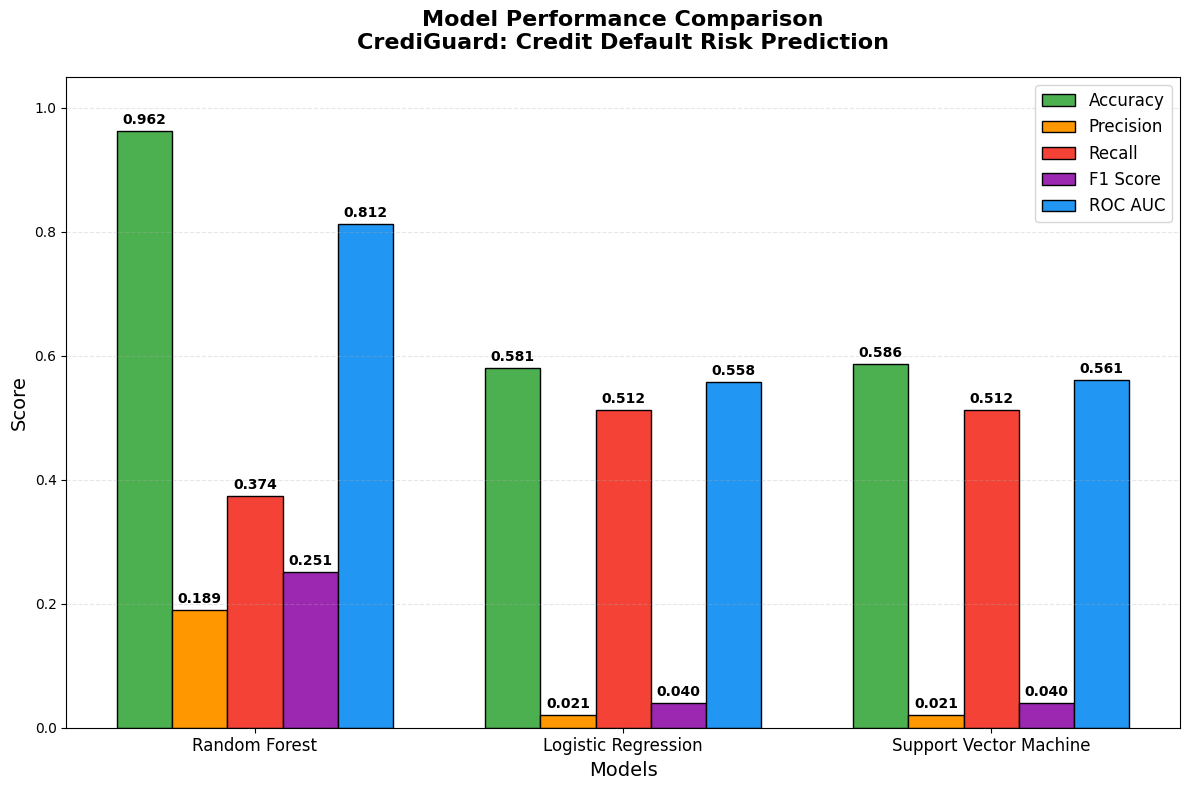

In [386]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Bar width and positions
bar_width = 0.15
index = np.arange(len(models))

# Create bars for each metric
bars1 = ax.bar(index - 2*bar_width, accuracy, bar_width, label='Accuracy', color='#4CAF50', edgecolor='black')
bars2 = ax.bar(index - bar_width, precision, bar_width, label='Precision', color='#FF9800', edgecolor='black')
bars3 = ax.bar(index, recall, bar_width, label='Recall', color='#F44336', edgecolor='black')
bars4 = ax.bar(index + bar_width, f1_score, bar_width, label='F1 Score', color='#9C27B0', edgecolor='black')
bars5 = ax.bar(index + 2*bar_width, roc_auc, bar_width, label='ROC AUC', color='#2196F3', edgecolor='black')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Model Performance Comparison\nCrediGuard: Credit Default Risk Prediction', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(index)
ax.set_xticklabels(models, fontsize=12)
ax.set_ylim(0, 1.05)
ax.legend(fontsize=12, loc='upper right')

#Add value labels on top of each bar
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)
add_value_labels(bars4)
add_value_labels(bars5)

# Improve layout
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Show the plot
plt.show()
